<a href="https://colab.research.google.com/github/Jorbnc/MAIA-DL/blob/master/Mini_Proyecto_1_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

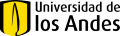

<style>
@import url('https://fonts.googleapis.com/css2?family=Latin+Modern+Roman:wght@400;700&display=swap');

body, p, h1, h2, h3, h4, h5, h6, li {
  font-family: 'Latin Modern Roman', serif;
}
code, pre {
  font-family: 'Fira Mono', monospace;
}
</style>

***

# **Mini Proyecto 1, Técnica de *Deep Learning*: Clasificación de MRI con Redes Neuronales Convolucionales para Tipos de Cáncer**

## **Descripción del problema:**

La **resonancia magnética** (MRI) es clave para detectar y clasificar tumores cerebrales. Gracias a las redes neuronales convolucionales (CNN), hoy podemos analizar estas imágenes con gran precisión, ya que las CNN aprenden a reconocer los patrones propios de cada tipo de tumor.

Un estudio completo de MRI genera un volumen 3D formado por muchas **capas bidimensionales**. Procesar el volumen entero resulta costoso en tiempo y recursos.

Para este proyecto abordaremos el problema de forma más ligera: trabajaremos solo con las imágenes 2D extraídas de cada capa. Así reducimos la carga computacional y convertimos la tarea en una clasificación de imágenes individuales, sin perder la información esencial para el diagnóstico.

## **Objetivo:**

Desarrollar un método basado en redes neuronales convolucionales que permita
clasificar con exactitud imágenes extraídas de MRIs en una de las 4 categorías.

- **Glioma**: Detecta masas anómalas con bordes irregulares y heterogeneidad en
el tejido cerebral.
- **Meningioma**: Identifica tumores bien delimitados originados en las meninges.
- **Pituitary**: Clasifica adenomas hipofisarios en la región selar.
- **Tejido sano**: Diferencia el tejido cerebral normal sin anomalías presentes

## **Resumen:**

Este notebook documenta la exploración y el preprocesamiento de un dataset de imágenes MRI (*Brain Tumor*), así como el entrenamiento, la validación con *early stopping* y la prueba de una adaptación y *fine-tuning* de la arquitectura CNN AlexNet, en su versión de PyTorch.

***

**Este proyecto es realizado por Andrés Felipe Ñungo y Jordan Bryan Núñez Campos para entrega el 2 de mayo.**


***

# Tareas:

* Ajustar el código para tomar un solo canal (Andrés Ñungo) ✅
* Tomar los papers investigar en la teoría como se debería ver un cerebro enfermo (Andrés Ñungo) ✅
* Mejorar la explicación del código  (Andrés y Jordan) ✅
* Carpetas descargadas a nivel del main (Jordan) ✅
* Organizar las referencias bibliográficas en PDF (Jordan) ✅
* Referenciar / mencionarlas las imágenes / plots (Andrés)  ✅
* Mapa de características ❌
* Explicación de la carga lazy en el PDF (Jordan) ⏳️
* En la metodología dentro del PDF: ⏳️
  - Hasta evaluación (Jordan) ⏳️
  - Evaluación (Andrés) ✅
* Número de parámetros (Andrés) ✅
* Matriz de confusión (Andrés) ✅
* Gráfica Accuracy /Loss vs epochs ✅

Pendientes potenciales:
* Un plot de los que nos enseñaron sobre la arquitectura de la red convolucional ❌

* Sería bueno sacar unas mini capas que muestren en conjunto la evolución de la imágen a medida que pasa por los diferentes kernels inspiración: https://poloclub.github.io/cnn-explainer/ ❌


***
# **Índice**

El *notebook* abordará el proyecto de la siguiente manera:

| 🔹 | Sección        |
|----|----------------|
| 1️⃣ | **Instalación y carga de librerías** |
| 2️⃣ | **Análisis exploratorio y preparación de los datos**       |
| 2️⃣.1️⃣ | **Carga y estadísticas generales**        |
| 2️⃣.2️⃣ | **Dimensiones y características cromáticas** |
| 2️⃣.3️⃣ | **Imágenes duplicadas**    |
| 3️⃣ | **Definición de *pipelines* de procesamiento**          |
| 3️⃣.1️⃣ | ***Pipeline* de preprocesamiento de imágenes**   |
| 3️⃣.2️⃣ | **Carga *lazy* de los datos mediante un subtipo de clase *Dataset***   |
| 4️⃣ | **Desarrollo del modelo CNN para clasificación de imágenes**   |
| 4️⃣.1️⃣ | **Hiperparámetros, partición y *Dataloaders***   |
| 4️⃣.2️⃣.1️⃣ | **Modelo: *AlexNet***   |
| 4️⃣.2️⃣ | **Adaptación a partir de la arquitectura *AlexNet***   |
| 4️⃣.3️⃣ | **Entrenamiento, validación y prueba**   |
| 5️⃣ | **Análisis de resultados y conclusiones**   |
| 5️⃣.1️⃣ | **Localización de tumores cerebrales**   |
| 6️⃣ | **Referencias**   |



***

# 1. Instalación y cargue de librerías

Empezamos por el cargue de las librerias que se usarán para efectos de este proyecto. Estas incluyen:

* Librerías comunes para la lectura, procesamiento y ploteo básico de las imágenes.
* **`kagglehub`**, para poder descargar el dataset del miniproyecto de forma conveniente
* **`hashlib`**, más adelante se explicará mejor, pero es una librería usada para usar el código criptográfico *HASH-256*, qué permitirá identificar duplicados.
* **`pytorch`** (de acuerdo, a la sugerencia del enunciado del proyecto), y particularmente su variante para visión computacional **`torchvision`**, ya que es una de las librerías más conocidas e intuitivas para trabajar el problema de clasificación de imágenes con CNNs[¹].

El uso específico de las librerías se detallará a medida que desarrollemos el notebook.

Adicionalmente nos aseguramos de ignorar alertamientos y de imprimir las versiones de las librerías usadas para que el ejercicio pueda ser replicable más adelante.

In [1]:
pip install kagglehub # Necesario para ejecutarse en Coursera

In [2]:
# Librerías comunes
import os
import pandas as pd
import numpy as np
import random
import time

# Obtención de la información
import kagglehub
from PIL import Image

# Librerías usadas para la preparación de los datos
import hashlib

# Modelado
import torch
import torch.nn as nn
from torch.utils.data import Dataset, random_split, DataLoader
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
import copy

# Evaluación
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

#Visualización de gráficas
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
%matplotlib inline

In [3]:
# Ignorar las warnings
import warnings
warnings.filterwarnings("ignore")

# Versiones utilizadas
from importlib.metadata import version
librerias = ['numpy', 'pandas', 'torch', 'torchvision', 'scikit-learn', 'kagglehub', 'pillow','matplotlib','seaborn']
for library in librerias:
  print(library, ": ", version(library))

numpy :  2.0.2
pandas :  2.2.2
torch :  2.6.0+cu124
torchvision :  0.21.0+cu124
scikit-learn :  1.6.1
kagglehub :  0.3.12
pillow :  11.2.1
matplotlib :  3.10.0
seaborn :  0.13.2


El siguiente bloque de código nos permite hacer determininísticas las funciones traídas de **`pytorch`**, y en general controlar todos los pseudo-aleatorios del *notebook*

In [4]:
# Definición del random state y seeds
RANDOM_STATE = 13
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

***

# 2. Análisis exploratorio y preparación de los datos


***

## 2.1. Carga y estadísticas generales

En primer lugar, nos encargamos de descargar correctamente las imágenes, teniendo en cuenta que vienen en carpetas separadas. Desde nuestra perspectiva, la mejor manera de organizar la información es vía un *dataframe*, cuya primera columna tenga la ruta de la imágen y en la segunda columna su respectiva etiqueta.

Almacenar solo las rutas de las imágenes nos permitirá cargar los datos solo cuando sean necesarios. Esto se detalla posteriormente en la sección **Pipeline de Preprocesamiento**.

In [5]:
# Descargar el conjunto de datos y almacenar el path en una variable
path_kaggle = kagglehub.dataset_download("rm1000/brain-tumor-mri-scans")
print("Ruta:", path_kaggle)

Ruta: /kaggle/input/brain-tumor-mri-scans


In [6]:
# Definición de labels a cargar
labels = ['glioma', 'healthy', 'meningioma', 'pituitary']
num_labels = len(labels)

# Indexamos cada label y también generamos el diccionario en sentido contrario
label2idx = {label: idx for idx, label in enumerate(labels)}
idx2label = {v: k for k, v in label2idx.items()}

# Por cada label, generar el path de su directorio
path_raiz = path_kaggle
path_por_label = {label: os.path.join(path_raiz, label) for label in labels}

# Dataframe con los paths de las imágenes y su label correspondiente
df_paths = []
for label, path in path_por_label.items():
    imagenes = os.listdir(path)
    for img in imagenes:
        # Solo procesar imágenes JPG
        if img.lower().endswith('.jpg'):
            img_path = os.path.join(path, img)
            df_paths.append({'img_path': img_path, 'label': label})
df_paths = pd.DataFrame(df_paths)

# Verificar dataframe
df_paths.sample(5)

,img_path,label
6442,/kaggle/input/brain-tumor-mri-scans/pituitary/...,pituitary
2531,/kaggle/input/brain-tumor-mri-scans/healthy/00...,healthy
4180,/kaggle/input/brain-tumor-mri-scans/meningioma...,meningioma
3149,/kaggle/input/brain-tumor-mri-scans/healthy/19...,healthy
5592,/kaggle/input/brain-tumor-mri-scans/pituitary/...,pituitary


Una vez teniendo esta información pre-cargada, hacemos un breve análisis de nuestro conjunto de datos. Empezando por la distribución de las clases:

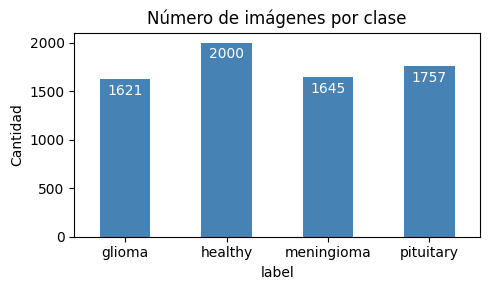

In [7]:
# Verificación de la distribución de las clases
counts = df_paths['label'].value_counts().sort_index()

# Gráfica con etiquetas numéricas
ax = counts.plot(kind='bar', rot=0, figsize=(5,3), color='steelblue')
ax.set_title('Número de imágenes por clase'); ax.set_ylabel('Cantidad')

# Añadir la etiqueta de cantidad encima de cada barra
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2, p.get_height() - 50),
                ha='center', va='top', fontsize=10, color='white')
plt.tight_layout(); plt.show()

Se puede observar que no hay sobre o sub-representación de las clases en el conjunto de datos original. Solo se observa una leve mayoría en el conjunto **`healthy`**.

Para tener una idea de cómo se visualizan las imágenes dependiendo de la clasificación de los tumores, se hace un mapeo en un mosaico muy sencillo sobre las muestras en el conjunto *brain tumor MRI*.

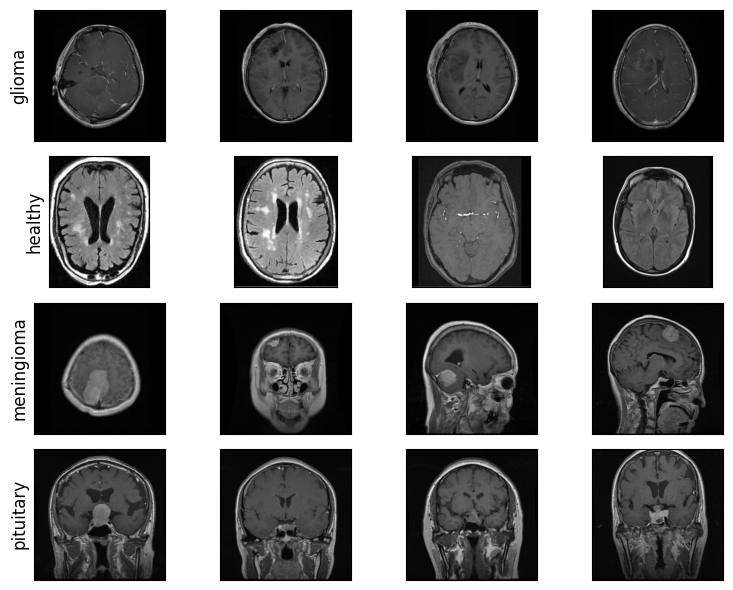

In [8]:
# Mosaico de muestras
fig, axes = plt.subplots(num_labels, 4, figsize=(8, 6))
for c, label in enumerate(labels):
    sample_paths = df_paths[df_paths.label == label].sample(4, random_state=RANDOM_STATE)['img_path']
    for r, p in enumerate(sample_paths):
        axes[c, r].imshow(Image.open(p))
        axes[c, r].set_yticklabels([]); axes[c, r].set_xticklabels([]);
        axes[c, r].set_yticks([]); axes[c, r].set_xticks([]);
        r == 0 and axes[c, r].set_ylabel(label, fontsize=12)
plt.tight_layout()
plt.show()

***

## 2.2. Dimensiones y características cromáticas
Por otro lado, es importante visualizar la resolución y proporción de aspecto (*aspect ratio*) de las imágenes para identificar características inusuales (*outliers*).

Text(0.5, 1.02, 'Distribución de resoluciones')

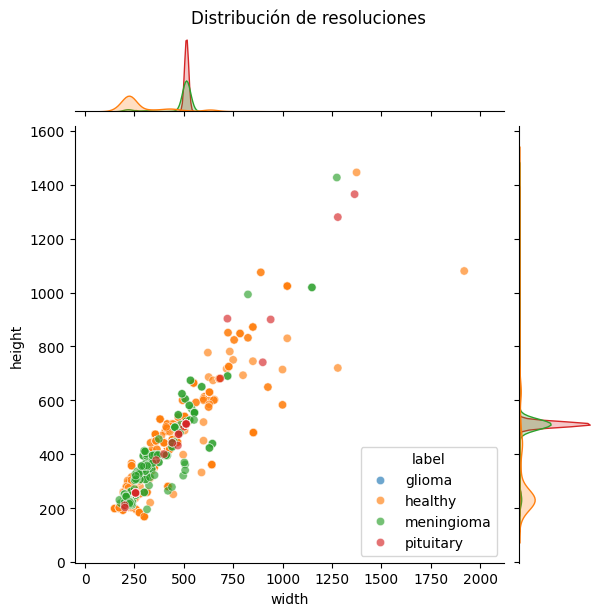

In [9]:
# Devuelve el tamaño (ancho x altura) de cada imagen
def get_size(path):
    with Image.open(path) as im:
        return im.size
df_paths[['width', 'height']] = df_paths['img_path'].apply(lambda p: pd.Series(get_size(p)))

# Jointplot
ax = sns.jointplot(data=df_paths, x='width', y='height', height=6, hue=df_paths['label'], alpha=0.65)
sns.move_legend(ax.ax_joint, "lower right")
plt.suptitle('Distribución de resoluciones', y=1.02)

La mayoría de las imágenes se concentran entre 200 px y 500 px en ambos ejes, formando una nube diagonal que evidencia una relación de aspecto casi constante. Unos pocos archivos superan los 1000 px; son imágenes mucho más grandes que el resto.

Para unificar el conjunto se aplicará un **`resize`** uniforme. Como las proporciones se mantienen estables, el escalado eliminará la varianza sin distorsionar el contenido; se pierde algo de detalle, pero se gana homogeneidad.

Después del redimensionamiento se calcularán la **media** y la **desviación estándar** globales de los canales. Esta normalización suavizará las variaciones de iluminación detectadas.

A continuación, confirmamos que el formato de los canales de las imágenes sean RGB:

In [10]:
# Verificación de canales
modes = df_paths['img_path'].apply(lambda p: Image.open(p).mode)
print(modes.value_counts())

img_path
RGB    7023
Name: count, dtype: int64


Antes de calcular la media y la desviación estándar para efectos de la normalización conviene mencionar que las MRI con contraste no contienen información cromática real; los tres canales son copias o casi copias de la misma señal de luminancia [²]. Por lo que es conveniente trabajar en escalas de grises, ya que no se pierde mucha información y permite reducir el uso de memoria.

Procedemos entonces a definir una función para dicho cálculo:

In [11]:
# Función para obtener la media y desviación estándar de grises para la normalización
def gray_mean_std(df):
  gray_sum, gray_sq_sum, pixel_count = 0.0, 0.0, 0

  for p in df['img_path']:
      img = np.asarray(Image.open(p).convert('L'), dtype=np.float32) / 255.0
      # suma de intensidades
      gray_sum += img.sum()
       # suma de intensidades al cuadrado
      gray_sq_sum += (img ** 2).sum()
      # número de píxeles (alto × ancho)
      pixel_count += img.size

  gray_mean = gray_sum / pixel_count
  gray_std = np.sqrt(gray_sq_sum / pixel_count - gray_mean ** 2)

  print(f"Media global (grayscale): {gray_mean:.5f}")
  print(f"Desv. estándar global: {gray_std:.5f}")

  return gray_mean, gray_std

In [12]:
gray_mean, gray_std = gray_mean_std(df_paths)

Media global (grayscale): 0.17375
Desv. estándar global: 0.18941


Esta media y desviación estándar serán utilizadas en el proceso de normalización que nos permite centrar en 0 y tener un varianza unitaria, lo que desde el punto de vista teórico disminuye el riesgo desvanecimiento del gradiente o de explosión respectivamente [³].

***

## 2.3. Imágenes duplicadas

Finalmente, para terminar con esta fase exploratoria, verificamos si hay duplicados para evitar la sobre-representación. Para ello se usa **`hashlib`**, librería que permite calcular la huella digital *SHA-256* en las imágenes. Su propósito principal es generar una clave única de longitud fija (256 bits = 32 bytes = 64 caracteres hexadecimales) a partir de cualquier bloque de datos. Este es un método común e intuitivo para identificar duplicados [⁴].

In [13]:
# Verificación de duplicado de datos
def sha256_file(path):
    with open(path, 'rb') as f:
        return hashlib.sha256(f.read()).hexdigest()

hashes = df_paths['img_path'].apply(sha256_file)
duplicados = hashes[hashes.duplicated(keep=False)]
print(f'Duplicados detectados: {duplicados.shape[0]}')

Duplicados detectados: 726


Tenemos **726** duplicados identificados por huella SHA-256 (esto se comprueba visualmente al final de esta sección), lo que sugiere que podríamos estar incurriendo en una ligera sobre-representación de alguna clase. Por tal motivo, limpiaremos el dataset dejando solo una instancia de las imágenes duplicadas.

El  dataset todavía tendrá suficientes imágenes únicas para entrenar una CNN. Por simplicidad metodológica eliminamos duplicados manteniendo solo la primera instancia. Note que son **726** **filas marcadas duplicadas**. Si nos quedamos por cada grupo de duplicados con un representante, la cantidad de datos limpios es mayor a la resta entre **7.023** y **726**.

In [14]:
# Calcula hash de cada fila
df_paths['hash'] = df_paths['img_path'].apply(sha256_file)

# Mantén la primera aparición de cada hash
df_clean = df_paths.drop_duplicates(subset='hash', keep='first').reset_index(drop=True)

print(f"Tamaño original: {len(df_paths):,}")
print(f"Tamaño limpio  : {len(df_clean):,}")

Tamaño original: 7,023
Tamaño limpio  : 6,597


Al graficar nuevamente la distribución de clases, notamos que la mayoría de imágenes duplicadas corresponden principalmente a la categoría `healthy`, y ligeramente a la categoría `meningioma`:

Reducción de 1 para glioma
Reducción de 294 para healthy
Reducción de 114 para meningioma
Reducción de 17 para pituitary


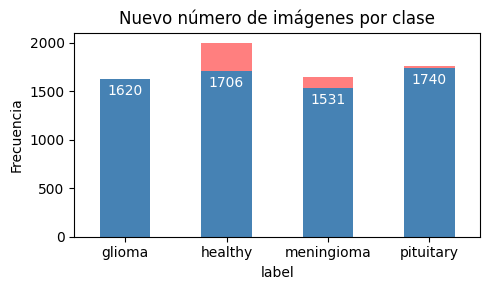

In [15]:
# Verificación de la distribución de las clases
counts = df_paths['label'].value_counts().sort_index()
counts_clean = df_clean['label'].value_counts().sort_index()
[print(f"Reducción de {a - b} para {labels[i]}") for i, (a, b) in enumerate(zip(counts,counts_clean))]

# Gráfica con etiquetas numéricas
ax = counts.plot(kind='bar', rot=0, figsize=(5,3), color='red', alpha=0.5)
counts_clean.plot(kind='bar', rot=0, color='steelblue')
ax.set_title('Nuevo número de imágenes por clase')
ax.set_ylabel('Frecuencia')

# Añadir la etiqueta de cantidad encima de cada barra
for p in ax.patches[4:]:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2, p.get_height() - 50),
                ha='center', va='top', fontsize=10, color='white')
plt.tight_layout(); plt.show()

La siguiente fución nos permitirá observar pares aleatorios de imágenes duplicadas, así como sus correspondientes nombres de archivo:

In [16]:
# Plotear aleatoriamente la primera y última ocurrencia de una imagen duplicada
def mostrar_duplicadas(df):

    # Filas con más de un hash count
    hash_counts = df['hash'].value_counts()
    duplicadas = hash_counts[hash_counts > 1].index

    # Elegir aleatoriamente
    hash_random = random.choice(duplicadas)
    grupo_duplicado_paths = df.loc[df['hash'] == hash_random, 'img_path']
    primera, ultima = [grupo_duplicado_paths.iloc[0], grupo_duplicado_paths.iloc[-1]]

    # Plot
    print("Imágenes duplicadas:")
    print("Primera ocurrencia:", primera); print("Última ocurrencia:", ultima)
    fig, (ax1, ax2) = plt.subplots(1,2)
    ax1.imshow(Image.open(primera)); ax1.axis('off')
    ax2.imshow(Image.open(ultima)); ax2.axis('off')
    plt.show()

Para el dataframe con duplicados, la función debe mostrar el par aleatorio de imágenes. Para el dataframe, debería ocurrir un `IndexError`:

Imágenes duplicadas:
Primera ocurrencia: /kaggle/input/brain-tumor-mri-scans/healthy/0090.jpg
Última ocurrencia: /kaggle/input/brain-tumor-mri-scans/healthy/1659.jpg


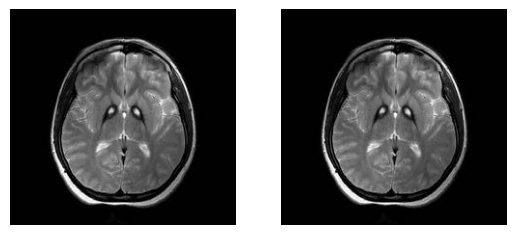

In [17]:
mostrar_duplicadas(df_paths)

In [18]:
try:
  mostrar_duplicadas(df_clean)
except IndexError:
  print("df_clean no contiene imágenes duplicadas")

df_clean no contiene imágenes duplicadas


Nuevamente es necesario calcular la media y desviación estándar de nuestros datos, esta vez con la limpieza hecha.

In [19]:
gray_mean, gray_std = gray_mean_std(df_clean)

Media global (grayscale): 0.17168
Desv. estándar global: 0.18712


***

# 3. Definición de *pipelines* de procesamiento

***

## 3.1. *Pipeline* de preprocesamiento de imágenes

Como base para el preprocesamiento se utiliza un estándar recomendado para la arquitectura neuronal *AlexNet* [⁵] y se modifica ligeramente. Esto nos permite un alistamiento y aumento de los datos a partir de los siguientes pasos:

*  Transformación a escala de grises para garantizar un solo canal, y a la vez reducir el uso de memoria sin perder información cromática relevante.

* Redimensionamiento a `256` pixeles. La lógica detallada de esta transformación es la siguiente: Si `size` es un `int`, la dimensión original más pequeña será reescalada a este número y la otra dimensión se transformará con la fórmula: $size * \frac{height}{width}$

* Rotación aleatoria ligera (*data augmentation*). Leves cambios de la imagen para permitir generalización del modelo, en este caso una rotación de 15 grados.

* Recorte del tamaño de las imágenes a `224x224` pixeles con **`CenterCrop`** (se asume que la información relevante a la presencia de tumores estaría centrada dentro la imagen, lo que en realidad suele ser común en este tipo de imágenes).

* Espejo horizontal (*data augmentation*). Leves cambios de la imagen para permitir generalización del modelo, en este caso una reflexiones sobre el eje horizontal aleatorias.

* **`ToTensor`** transformación al objeto tomado por defecto en las herramientas de **`Pytorch`**

* Normalización de los datos restando media y dividiendo sobre la desviación estándar para reducir el riesgo de gradiente pequeño o explosivo.

In [20]:
# Pipeline de preprocesamiento recomendado
transform_pipeline = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize(256),
    transforms.RandomRotation(15),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((gray_mean,), (gray_std,))
])

***

## 3.2. Carga *lazy* de los datos mediante un subtipo de la clase Dataset

La siguiente clase de **`PyTorch`** permite cargar las imágenes utilizando *lazy evaluation* [⁶][⁷]. Esto hace que los datos se lean **justo a tiempo** (JIT)—solo cuando **`getitem`** (e.g., **`dataset[idx]`**) es invocado por el **`DataLoader`**— en lugar de cargarlos todos en la memoria al iniciar el entrenamiento. De este modo, se optimiza el uso de la RAM del CPU y se evita la saturación de la memoria de la GPU al enviar únicamente un batch a la vez.



In [21]:
# Subclase de Dataset (PyTorch) para cargar más eficientemente la data -> Lazy evaluation
class ImgDataset(Dataset):
  def __init__(self, df, transformacion, label2idx:dict = None):
    self.df = df
    self.transformacion = transformacion
    self.label2idx = label2idx

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    fila = self.df.iloc[idx]
    img_path = fila['img_path']
    label = fila['label']

    # Si se pasa label2idx, estos se convierten a índices con base en label2idx
    if self.label2idx:
      label = self.label2idx[label]

    # Leer imagen y aplicar transformación custom
    with Image.open(img_path) as img:
      img = self.transformacion(img)

    return img, label

In [22]:
# Instanciación de la clase de Dataset
dataset = ImgDataset(df_clean, transformacion=transform_pipeline, label2idx=label2idx)

In [23]:
# Ejemplo de una carga individual
random_idx = random.randint(0,len(dataset))
tensor, etiqueta = dataset[random_idx]
print("Dimensiones estandar de imagen con un solo canal: ", tensor.shape)
print("Etiqueta numérica: ", etiqueta)

Dimensiones estandar de imagen con un solo canal:  torch.Size([1, 224, 224])
Etiqueta numérica:  1


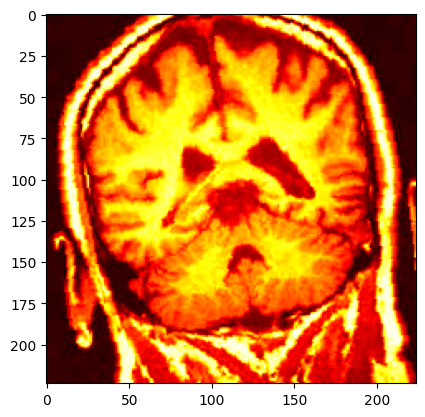

In [24]:
# Ejemplo del ploteo de una imagen
# Convertir de Tensor a Numpy
def tensor2numpy(tensor):
  return tensor.permute(1, 2, 0).numpy()

# Ahora es posible aplicar un cmap ya que el np.array tiene dimensiones (1, filas, columnas)
plt.imshow(tensor2numpy(dataset[random_idx][0]), cmap='hot')

***

# 4. Desarrollo del modelo CNN para clasificación de imágenes

***

## 4.1. Hiperparámetros, partición y *DataLoaders*

Ya que implementaremos entrenamiento y validación con *early stopping*, es necesario definir la "paciencia", i.e., un umbral que indica detener el entrenamiento si no hay mejorías durante un determinado número de *epochs*.

In [25]:
# Hiperparámetros del loop de entrenamiento
batch_size = 32
num_epochs = 50
umbral_epochs = 10

Se usa una partición **80/10/10** para los datos de entrenamiento, validación y *test*, respectivamente. También se define **`device`** que nos permitirá ir alternado el uso de GPU y de CPU.

In [26]:
# Trabajar en GPU/CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Partición de los datos
size_dataset  = len(dataset)
size_entrenmiento = int(0.8 * size_dataset)
size_validacion = int(0.1 * size_dataset)
size_test = size_dataset - size_entrenmiento - size_validacion
dataset_train, dataset_val, dataset_test = random_split(
    dataset,
    [size_entrenmiento, size_validacion, size_test],
    generator=torch.Generator().manual_seed(RANDOM_STATE)
)

# Carga "lazy" de las particiones
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(dataset_val,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(dataset_test,  batch_size=batch_size, shuffle=False)

***

## 4.2. Adaptación a partir de la arquitectura AlexNet

</span>

***
### 4.2.1 Modelo: AlexNet

*AlexNet* es capaz de detectar tanto bordes como patrones complejos. Además, al estar pre-entrenado en *ImageNet*, acelera y facilita la adaptación a nuestra nueva tarea. No obstante, dado que trabajamos con un conjunto de datos relativamente pequeño, todos sus parámetros se mantendrán entrenables.

En líneas generales, *AlexNet* ofrece un equilibrio óptimo entre profundidad y velocidad de cómputo. Su arquitectura se puede describir así:

**Arquitectura:**
- **Bloque de extracción de características :**  
  1. Conv1: 64 filtros 11×11, stride 4 → ReLU → MaxPool (3×3, stride 2)  
  2. Conv2: 192 filtros 5×5 → ReLU → MaxPool (3×3, stride 2)  
  3. Conv3: 384 filtros 3×3 → ReLU  
  4. Conv4: 256 filtros 3×3 → ReLU  
  5. Conv5: 256 filtros 3×3 → ReLU → MaxPool (3×3, stride 2)  
- **AdaptiveAvgPool:** reduce a 6×6  
- **Clasificador:**  
  - Dropout(0.5) → FC(9216→4096) → ReLU  
  - Dropout(0.5) → FC(4096→4096) → ReLU  
  - FC(4096→1000)

Como se muestra en la ejecución de la siguiente celda, esta arquitectura tiene originalmente **`61,100,840`** parámetros (lo cual se puede comprobar en [este enlace](https://pytorch.org/vision/main/models/generated/torchvision.models.alexnet.html)).

In [27]:
# Cargar modelo
model = models.alexnet(pretrained=True)

# Número de parámetros de la arquitectura sin modificaciones
total_parametros = sum(p.numel() for p in model.parameters())
print(f"Total parametros {total_parametros:,}\n")

# Observamos la arquitectura del modelo original
model

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:03<00:00, 80.4MB/s]


Total parametros 61,100,840



AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Notamos que los siguientes ajustes son necesarios:
- La entrada a la red debe admitir un solo canal de color $\implies$ Modificar **`model.features[0]`**.
- La última capa completamente conectada debe tener 4 neuronas $\implies$ Modificar **`model.classifier[6]`**.

Adicionalmente podemos efectuar otros cambios en la CNN que en realidad estarían sujetos a un proceso de elección de hiperparámetros. En nuestro caso, los cambios opcionales detallados en la siguiente celda fueron producto de la experimentación, sin embargo, podrían mejorarse de forma más sistemática. Estos incluyen:
- Reducción de la probabilidad de **`Dropout`**, de **`0.5`** a **`0.25`**, para evitar *underfitting*.
- Reducción del número de neuronas en las capas completamente conectadas (se observó una capacidad de generalización muy similar a la de la red original, pero con un desempeño más eficiente).

Los componentes: tamaño de *kernel*, *stride*, *padding*, función de activación y *pooling* se mantienen intactos.

In [28]:
# Adaptando AlexNet para nuestra aplicación

# Modificamos la capa de entrada en features para aceptar un solo canal
model.features[0] = nn.Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))

# Cambios opcionales
model.classifier[0] = nn.Dropout(p=0.25, inplace=False)
model.classifier[1] = nn.Linear(in_features=9216, out_features=2048, bias=True)
model.classifier[3] = nn.Dropout(p=0.25, inplace=False)
model.classifier[4] = nn.Linear(in_features=2048, out_features=512, bias=True)

# Modificamos la capa final del classifier para un output de 4 labels
model.classifier[6] = nn.Linear(512, num_labels)

# Observemos la arquitectura del modelo adaptado para nuestro caso
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.25, inplace=False)
    (1): Linear(in_features=9216, out_features=2048, bias=True)


In [29]:
# Número de parámetros total
total_parametros = sum(p.numel() for p in model.parameters())
print(f"Total parametros: {total_parametros:,} (arquitectura modificada)\n")

Total parametros: 22,381,764 (arquitectura modificada)



El modelo resultante tiene en total **`22,381,764`** parámetros entrenables que serán ajustados al dataset, buscando una buena generalización mediante early stopping.

***

## 4.3. Entrenamiento, validación y prueba

La implementación se organiza en cuatro etapas principales:

1. **Configuración inicial**: Mover el modelo a **`device`**, definir **`loss_f`** y crear el optimizador eligiendo  **`Adam`**

2. **Definición de función de evaluación de precisión**: Activar modo evaluación y recorrer  **`test_loader`** sin gradientes, calculando el *accuracy*.

3. **Bucle de entrenamiento**:Para cada *epoch* se ejecuta la fase de entrenamiento (**`model.train()`**), recorre el **`train_loader`**, calcula la pérdida (**`loss.backward()`**), aplica *back-propagation* y actualiza los pesos (**`optimizer.step()`**) y se registra la pérdida media de entrenamiento (**`train_loss`**). En la fase de validación se  evalúa el modelo sobre **`val_loader`** y obtiene la pérdida media de validación (**`val_loss`**).  Finalmente se calcula y almacena el accuracy.

4. **Estrategia de *Early Stopping***: Se definen las variables de control: **`mejor_loss_val`**, **`val_loss`**.
     - Si **`val_loss`** mejora, se actualizan las variables y el contador se reinicia.  
     - Si no mejora, el contador aumenta; al superar **`umbral_epochs`** se detiene el entrenamiento y se restauran los **pesos óptimos**.

Finalmente, preserva el modelo con la mejor métrica de validación, evitando el sobre-ajuste y reduciendo el tiempo de cómputo.


In [30]:
# Cargar al device elegido
model = model.to(device)

In [31]:
# Función de pérdida y optimizador
loss_f = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=5e-5)

In [32]:
# Función para calcular el accuracy
def evaluar_modelo_accuracy(m):
  # Modo evaluación
  m.eval()
  correctos, total = 0, 0
  # Desactivar ajuste de parámetros y calcular accuracy
  with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        logits = m(imgs)
        # Obtener el índice (clase) de logit máximo a lo largo de la dim=1
        _, predicciones = torch.max(logits, 1)
        # Actualización iterativa del accuracy
        correctos += (predicciones == labels).sum().item()
        total += labels.size(0)
  return correctos / total * 100

In [33]:
train_loss_acumulado = []
val_loss_acumulado = []
accuracy_acumulado = []

# Las siguientes variables forman parte de la implementación de Early Stopping:
# Copia inicial del estado del modelo
pesos_mejor_modelo = copy.deepcopy(model.state_dict())
# 'mejor loss'. Se inicializa en un valor infinto positivo
mejor_loss_val  = float('inf')
# Contador de epochs sin mejora significativa
epochs_sin_mejora = 0

start_time = time.time()
# Loop de entrenamiento con Early Stopping
for epoch in range(1, num_epochs+1):

    # Entrenamieto
    model.train() # Cambia a modo de entrenamiento y permite Dropout
    loss_acumulada = 0.0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        # Backpropagation y Ajuste de parámetros
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = loss_f(outputs, labels)
        loss.backward()
        optimizer.step()
        loss_acumulada += loss.item() * imgs.size(0)

    # Métrica de entrenamiento para la epoch actual
    train_loss = loss_acumulada / len(train_loader.dataset)
    train_loss_acumulado.append(train_loss)

    # Validación
    model.eval()
    val_loss = 0.0
    # Desactiva la actualización de parámetos (no gradient) y activa el modo inferencia
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = loss_f(outputs, labels)
            val_loss += loss.item() * imgs.size(0)
    val_loss /= len(val_loader.dataset)
    val_loss_acumulado.append(val_loss)

    # Prueba iterativa
    acc = evaluar_modelo_accuracy(model)
    accuracy_acumulado.append(acc)

    # Early stopping
    # Si es que hay mejoría...
    if val_loss < mejor_loss_val:
        # ...actualizar el mejor loss
        mejor_loss_val = val_loss
        pesos_mejor_modelo = copy.deepcopy(model.state_dict())
        # Y reiniciar el contador de epochs
        epochs_sin_mejora = 0
        print(f"Epoch {epoch}/{num_epochs}, Train Loss: {train_loss:.4f},  Val Loss: {val_loss:.4f} --> Nueva mejor métrica (Test Accuracy: {acc:.2f}%)")
    # En caso contrario, seguir iterando hasta superar el umbral o finalizar todas las epochs
    else:
        epochs_sin_mejora += 1
        print(f"Epoch {epoch}/{num_epochs}, Train Loss: {train_loss:.4f},  Val Loss: {val_loss:.4f} (Test Accuracy: {acc:.2f}%)")
        if epochs_sin_mejora >= umbral_epochs:
            print(f"→ Early stopping después de {epoch} epochs.")
            break

end_time = time.time()
print(f"Completado en {(end_time - start_time) / 60.0} minutos.")

Epoch 1/50, Train Loss: 0.5282,  Val Loss: 0.3255 --> Nueva mejor métrica (Test Accuracy: 86.69%)
Epoch 2/50, Train Loss: 0.2598,  Val Loss: 0.1702 --> Nueva mejor métrica (Test Accuracy: 93.80%)
Epoch 3/50, Train Loss: 0.1929,  Val Loss: 0.2059 (Test Accuracy: 91.38%)
Epoch 4/50, Train Loss: 0.1418,  Val Loss: 0.1412 --> Nueva mejor métrica (Test Accuracy: 95.31%)
Epoch 5/50, Train Loss: 0.1069,  Val Loss: 0.1099 --> Nueva mejor métrica (Test Accuracy: 95.61%)
Epoch 6/50, Train Loss: 0.0870,  Val Loss: 0.1290 (Test Accuracy: 95.31%)
Epoch 7/50, Train Loss: 0.0713,  Val Loss: 0.1012 --> Nueva mejor métrica (Test Accuracy: 96.07%)
Epoch 8/50, Train Loss: 0.0551,  Val Loss: 0.1032 (Test Accuracy: 97.13%)
Epoch 9/50, Train Loss: 0.0505,  Val Loss: 0.0928 --> Nueva mejor métrica (Test Accuracy: 95.76%)
Epoch 10/50, Train Loss: 0.0356,  Val Loss: 0.0822 --> Nueva mejor métrica (Test Accuracy: 97.73%)
Epoch 11/50, Train Loss: 0.0256,  Val Loss: 0.1012 (Test Accuracy: 96.22%)
Epoch 12/50, Tra

In [34]:
# Cargar mejores parámetros
model.load_state_dict(pesos_mejor_modelo)

<All keys matched successfully>

***


# 5. Análisis de resultados y conclusiones

Definimos la función **`evaluar_test()`**  que recorre el *DataLoader* de prueba en modo inferencia, acumula **`y_true`** y **`y_pred`**, calculando *Accuracy*, *F1-macro* y la *Matriz de confusión*

Tras recargar los pesos del mejor modelo se ejecuta **`evaluar_test`**, se hace una impresión en consola y se hace una visualización de **`cm_test`** con **`seaborn.heatmap`**, mostrando etiquetas reales (eje Y) vs. predicciones (eje X). De esta manera se proporciona de forma compacta las métricas clave y un diagnóstico visual de los aciertos y errores del modelo sobre el conjunto de prueba.

In [35]:
#Devuelve y_true, y_pred, accuracy y F1-macro.
def evaluar_test(modelo, loader, device):

    modelo.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = modelo(x)
            _, pred = torch.max(logits, 1)
            y_true.extend(y.cpu().numpy())
            y_pred.extend(pred.cpu().numpy())
    # Accuracy
    acc  = accuracy_score(y_true, y_pred)
    # F1 multi-clase
    f1   = f1_score(y_true, y_pred, average='macro')  #
    cm   = confusion_matrix(y_true, y_pred)
    return acc, f1, cm, y_true, y_pred


Resultados en TEST
‣ Accuracy :  97.88%
‣ F1-macro :  0.978


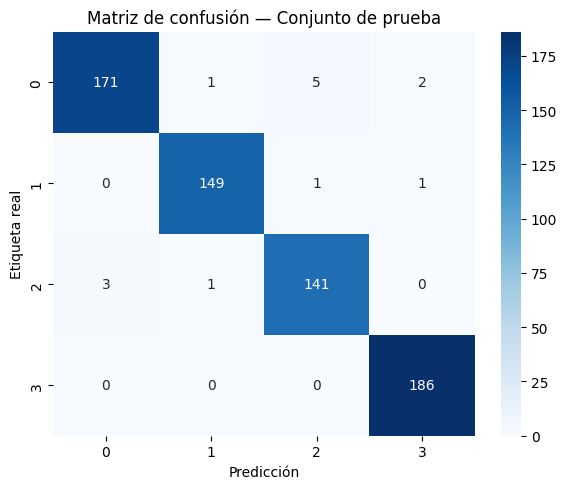

In [36]:
# Evaluar sobre test
acc_test, f1_test, cm_test, y_true, y_pred = evaluar_test(model, test_loader, device)

# Print métricas
print("\nResultados en TEST")
print(f"‣ Accuracy : {acc_test*100:6.2f}%")
print(f"‣ F1-macro : {f1_test:6.3f}")


# Convierte cada etiqueta a int
class_ids   = sorted(set(y_true))
class_names = [str(c) for c in class_ids]

# Plot matriz de confusión
plt.figure(figsize=(6, 5))
sns.heatmap(cm_test,
            annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicción")
plt.ylabel("Etiqueta real")
plt.title("Matriz de confusión — Conjunto de prueba")
plt.tight_layout()
plt.show()

Se puede observar que el modelo tiene gran precisión de predicción para la mayoría de las clases teniendo tan solo entre 3-5 errores exceptuando en la clase **meningioma** donde se observa que tiende a predecir erróneamente algunas imágenes de la clase **glioma**, clasificándolas en **meningioma**. Más adelante se explicará por qué puede ocurrir esta confusión. El *accuracy* obtenido es de al rededor del 97%, lo que no está para nada mal, teniendo en cuenta además que no hay desbalance de clases. También el *F1-Score* es bueno aunque no dice mucha información adicional al *accuracy* ya que esta es una métrica que cobra especial valor en clases desbalanceadas.

En el siguiente gráfico se observa la variación de las métricas *Val Loss* y *Test Accurac*y. Podríamos estabilizarlas reduciendo aún más la tasa de aprendizaje, aunque esto incrementaría el tiempo de entrenamiento.

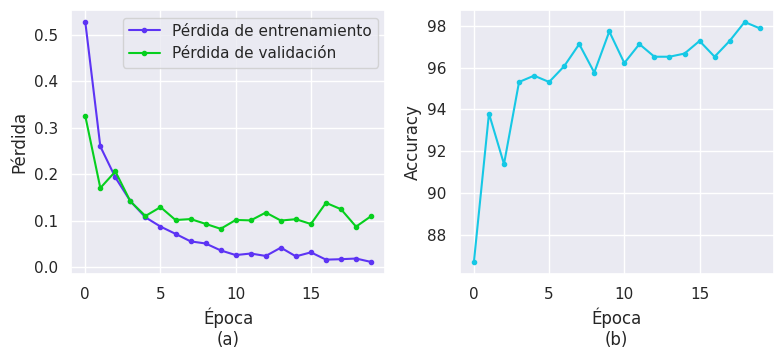

In [37]:
sns.set(style="darkgrid")

fig, axes = plt.subplots(1, 2, figsize=(8, 3.75))

axes[0].plot(train_loss_acumulado, label='Pérdida de entrenamiento', color = '#5d34f4', marker = ".", lw= 1.5)
axes[0].plot(val_loss_acumulado, label='Pérdida de validación', color = '#06cf1e', marker = ".", lw= 1.5)
axes[0].set_xlabel('Época\n(a)')
axes[0].set_ylabel('Pérdida')
axes[0].legend()
#axes[0].set_title('Pérdidas de entrenamiento y validación')

axes[1].plot(accuracy_acumulado, label='Test Accuracy', color='#16c8e5', marker = ".")
axes[1].set_xlabel('Época\n(b)')
axes[1].set_ylabel('Accuracy')
#axes[1].set_title('Test Accuracy')

plt.tight_layout()
plt.savefig("resultados_plot.png", dpi=300)

***
## 5.1 Localización de tumores cerebrales

A continuación se muestran algunos ejemplos encontrados en diferentes fuentes académicas sobre cada uno de los tumores planteados en el proyecto. Esto dará una mejor idea de lo que se debe observar en las imágenes clasificadas.

<p float="left">
  <img src="https://i.ibb.co/d0SknXpR/Ejemplo-Glioma.jpg"   alt="Glioma"       width="200px"/>
  <img src="https://i.ibb.co/0y5r5Hq1/Ejemplo-Meningioma.jpg" alt="Meningioma"   width="200px"/>
  <img src="https://i.ibb.co/Q3sQSLdG/Ejemplo-Pituitario.jpg"  alt="Pituitary"    width="200px"/>
</p>

Por supuesto, no somos expertos en la materia, sin embargo, se hace una muy simplificada interpretación de lo que según los artículos científicos se debe observar en cada caso.

* **Glioma**: "...*lesión intraaxial con márgenes irregulares y aspecto heterogéneo en secuencias T1 y FLAIR (fases cerebrales); muestra realce no uniforme tras gadolinio y suele infiltrar la sustancia blanca adyacente*...". Fuente [⁸]. **Interpretación**: Se suele ver una zona blanca alrededor del tumor de gran tamaño que suele ser irregular.

* **Meningioma**: "...*masa extraaxial, bien delimitada y adosada a la duramadre, de señal iso-hiperintensa en T1; tras contraste presenta realce homogéneo y a menudo signo de “cola dura”*..." . Fuente [⁹] **Interpretación**: Tumor bien delimitado, compacto y de realce homogéneo.


* **Adenoma pituitario:** "...*lesión redondeada en la silla turca, iso- a hipointensa en T1, con realce uniforme tras gadolinio; puede crecer supraselar y desplazar las estructuras vecinas (e.g., quiasma óptico)*...". Fuente [¹⁰] **Interpretación**: Forma redonda en una zona muy específica (señalada en la imagen) y realce homogéneo.

Se puede observar que en el caso del **meningioma** y del **glioma** comparten rasgos morfológicos  y que se diferencian en patrones finos que aún el modelo no logra capturar.

Teniendo en cuenta el análisis anterior se procede a generar algunos ejemplos de las clasificación obtenida a partir del modelo CNN entrenado

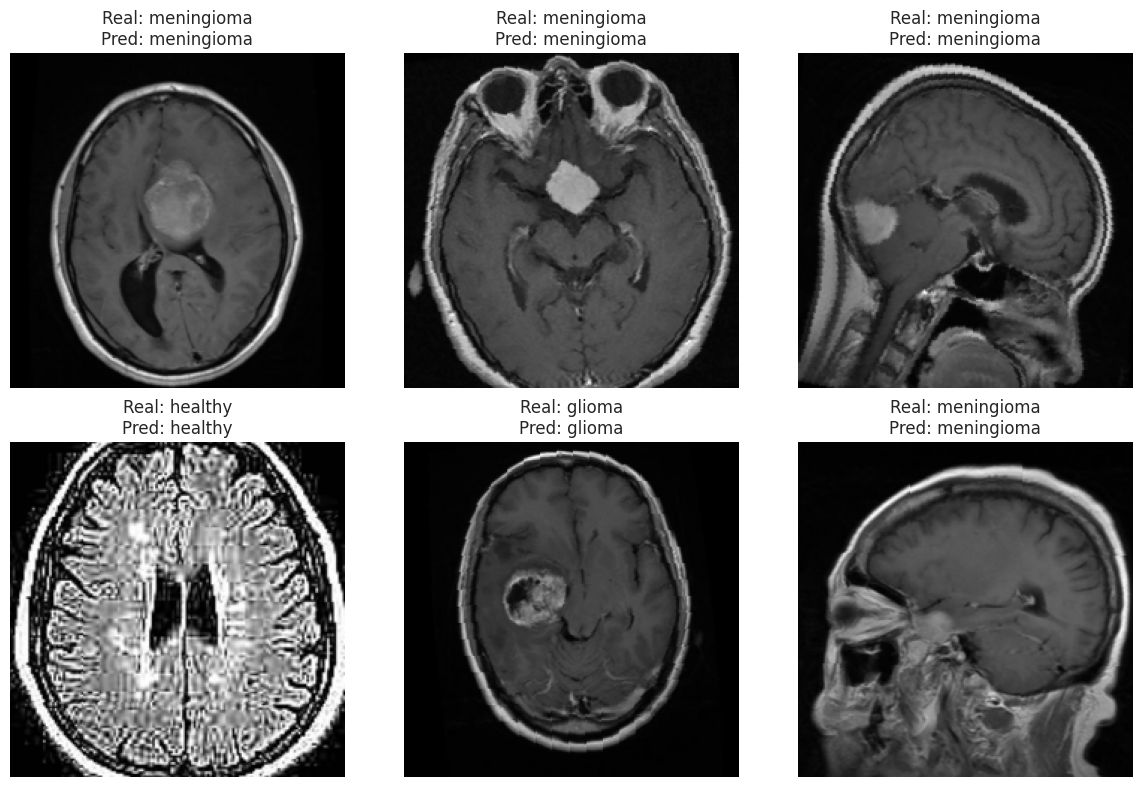

In [38]:
# Visualizador de predicciones
def visualizar_predicciones(model, loader, idx2label, device, n_imagenes=6):
    # Modelo en modo evaluación
    model.eval()
    images_shown = 0

    # Calcula filas y columnas según n_imagenes
    ncols = 3
    nrows = int(np.ceil(n_imagenes / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*4))
    # Aplanamos para indexar fácilmente
    axes = axes.flatten()

    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            # Propagación hacia adelante
            outputs = model(imgs)
            # outputs.shape = (batch_size, num_classes)
            # preds es un tensor de tamaño (batch_size,) con la clase de máxima probabilidad
            _, preds = torch.max(outputs, dim=1)

            # Recorremos las imágenes del batch
            for i in range(imgs.size(0)):
                if images_shown >= n_imagenes:
                    break
                ax = axes[images_shown]
                img = imgs[i].cpu().permute(1,2,0).numpy()
                # Si es monocanal (canal único), matplotlib espera un 2D, así que:
                if img.shape[2] == 1:
                    img = img[:,:,0]
                    ax.imshow(img, cmap='gray')
                else:
                    ax.imshow(img)

                # Obtenemos etiquetas como strings
                true_label = idx2label[labels[i].item()]
                pred_label = idx2label[preds[i].item()]
                ax.set_title(f"Real: {true_label}\nPred: {pred_label}")
                ax.axis('off')
                images_shown += 1

            if images_shown >= n_imagenes:
                break

    plt.tight_layout()
    plt.show()

visualizar_predicciones(model, test_loader, idx2label, device, n_imagenes=6)

La siguiente imagen es tomada de una de las ejecuciones de la función anterior. Según lo aprendido de la bibliografía relacionada, se puede analizar algunas razones por las cuales el clasificador tuvo las respectivas predicciones:

<p float="left">
  <img src="https://i.ibb.co/M5gZNrcq/predicciones-2.png"   alt="Mosaico"       width="500px"/>
</p>

Se desarrolla el análisis caso a caso:

- **Tumores hipofisarios:** Se observa que la MRI genera contraste en la zona de la glándula pituitaria.
- **Tumor glioma:** Caracterizado por una zona amplia, no muy bien definida y de forma oblongada.
- **Tumor Meningioma:** Caracterizado por un contraste bastante homogéneo y localizado en la zona señalada.

En conclusión, el modelo de redes convolucionales entrenado, es un versión simplificada y didáctica respecto a lo que hoy en día se puede llegar con este tipo de modelos. Sin embargo, presenta un desempeño decente y permite establecer hipótesis sobre las características evaluadas en las imágenes para poder llegar a cada clasificación.

***


# 6. Referencias


[¹] **Pytorch, entrenando un clasificador**  
Disponible en: [Pytorch.org](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)

[²] **MRI sequences (overview), Radiopaedia.org**  
Disponible en: [radiopaedia.org](https://radiopaedia.org/articles/mri-sequences-overview?embed_domain=staging.radpair.comfavicon.icofavicon.icoradiopaedia-icon-144.png&lang=us)

[³] **Image Normalization in PyTorch**  
Disponible en: [medium.com](https://medium.com/%40piyushkashyap045/image-normalization-in-pytorch-from-tensor-conversion-to-scaling-3951b6337bc8)

[⁴] **Harnessing Python and SHA-256: An intuitive guide to removing duplicate files**  
Disponible en: [medium.com](https://medium.com/gitconnected/harnessing-python-and-sha-256-an-intuitive-guide-to-removing-duplicate-files-d3b02e0b3978)

[⁵] **AlexNet, by Pytorch Team**  
Disponible en: [pytorch.org](https://pytorch.org/hub/pytorch_vision_alexnet/)

[⁶] **Lazy Evaluation (Wikipedia)**
Disponible en: [en.wikipedia.org](https://en.wikipedia.org/wiki/Lazy_evaluation)

[⁷] **PyTorch Dataset Class**
Disponible en: [pytorch.org](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset)

[⁸] **“Glioma” con contornos que delimitan las zonas de tumor de alta y baja intensidad en T1 y FLAIR**
Disponible en: [Radiology Key](https://radiologykey.com/glioma/)

[⁹] **Serie de cortes de resonancia con flechas que señalan un meningioma dural, pre y post‐contraste**
Disponible en: [Lumen Neuroscience Curriculum](https://www.lumen.luc.edu/lumen/meded/radio/curriculum/neuroscience/meningioma1.htm)

[¹⁰] **Imagen de MRI con contraste mostrando un gran adenoma hipofisario señalado con flechas**
Disponible en: [msdmanuals](https://www.msdmanuals.com/es/professional/multimedia/image/microadenoma-hipofisario)